In [1]:
import torch
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
sys.path.append('../')

import DRLPDE.neuralnets as neuralnets
import importlib

mpl.rcParams['figure.dpi'] = 600
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 8

# 2**13 points, 
# direct -- 100,000 steps with ResNet
# direct_feedforward -- 100,000 steps with FeedForward
# stochastic -- 100,000 steps with ResNet

In [6]:
test = 'stochastic_resnet'
title = 'Solving Laplace\'s Equation'

error_levels = np.linspace(-0.6, 0.6, 31)
error_tick = np.linspace(-0.6, 0.6, 7)

with open('../experiments/' + test + '_parameters.pickle', 'rb') as f:
    parameters = pickle.load(f)

with open('../experiments/'  + test + '_losses.pickle', 'rb') as f:
    losses = pickle.load(f)

with open('../experiments/'  + test + '_errors.pickle', 'rb') as f:
    errors = pickle.load(f)

In [7]:
problem = importlib.import_module(".example1", package='examples')

input_dim = [problem.x_dim, problem.t_dim, problem.hyper_dim]
output_dim = problem.output_dim

with open('../experiments/' + test + '_parameters.pickle', 'rb') as f:
    parameters = pickle.load(f)

if parameters['neuralnetwork'] == 'FeedForward':
    MyNeuralNetwork = neuralnets.FeedForwardNN
elif parameters['neuralnetwork'] == 'Incompressible':
    MyNeuralNetwork = neuralnets.IncompressibleNN
elif parameters['neuralnetwork'] == 'ResNet':
    MyNeuralNetwork = neuralnets.ResNetNN

nn_size = parameters['nn_size']

model = MyNeuralNetwork(input_dim, output_dim, **nn_size)
model.load_state_dict(torch.load("../savedmodels/" + test + ".pt"))

[ [xmin, xmax], [ymin, ymax]] =  problem.boundingbox

true_fun = problem.true_fun
polar_eq = problem.polar_eq

num_th = 120
num_r = 20

th = torch.linspace(0,2*math.pi, num_th)
r = torch.zeros(num_r, num_th)
for ii in range(num_th):
    r[:,ii] = torch.sqrt( torch.linspace( 0, 1, num_r) )*polar_eq(th[ii])
r = r.reshape(-1)

rth = torch.stack((r, th.repeat(num_r)), dim=1)
X = torch.stack( (rth[:,0]*torch.cos( rth[:,1] ), rth[:,0]*torch.sin( rth[:,1])), dim=1)
#X = X[num_th-1:,:]
#size = num_th*(num_r-1) + 1 

Y = model(X).detach().reshape(num_r, num_th).numpy()
Ytrue = true_fun(X).detach().reshape(num_r, num_th).numpy()

Xplot = X[:,0].detach().reshape(num_r, num_th).numpy()
Yplot = X[:,1].detach().reshape(num_r, num_th).numpy()

### Plotting Contours

Text(0.5, 1.0, 'Loss vs Error')

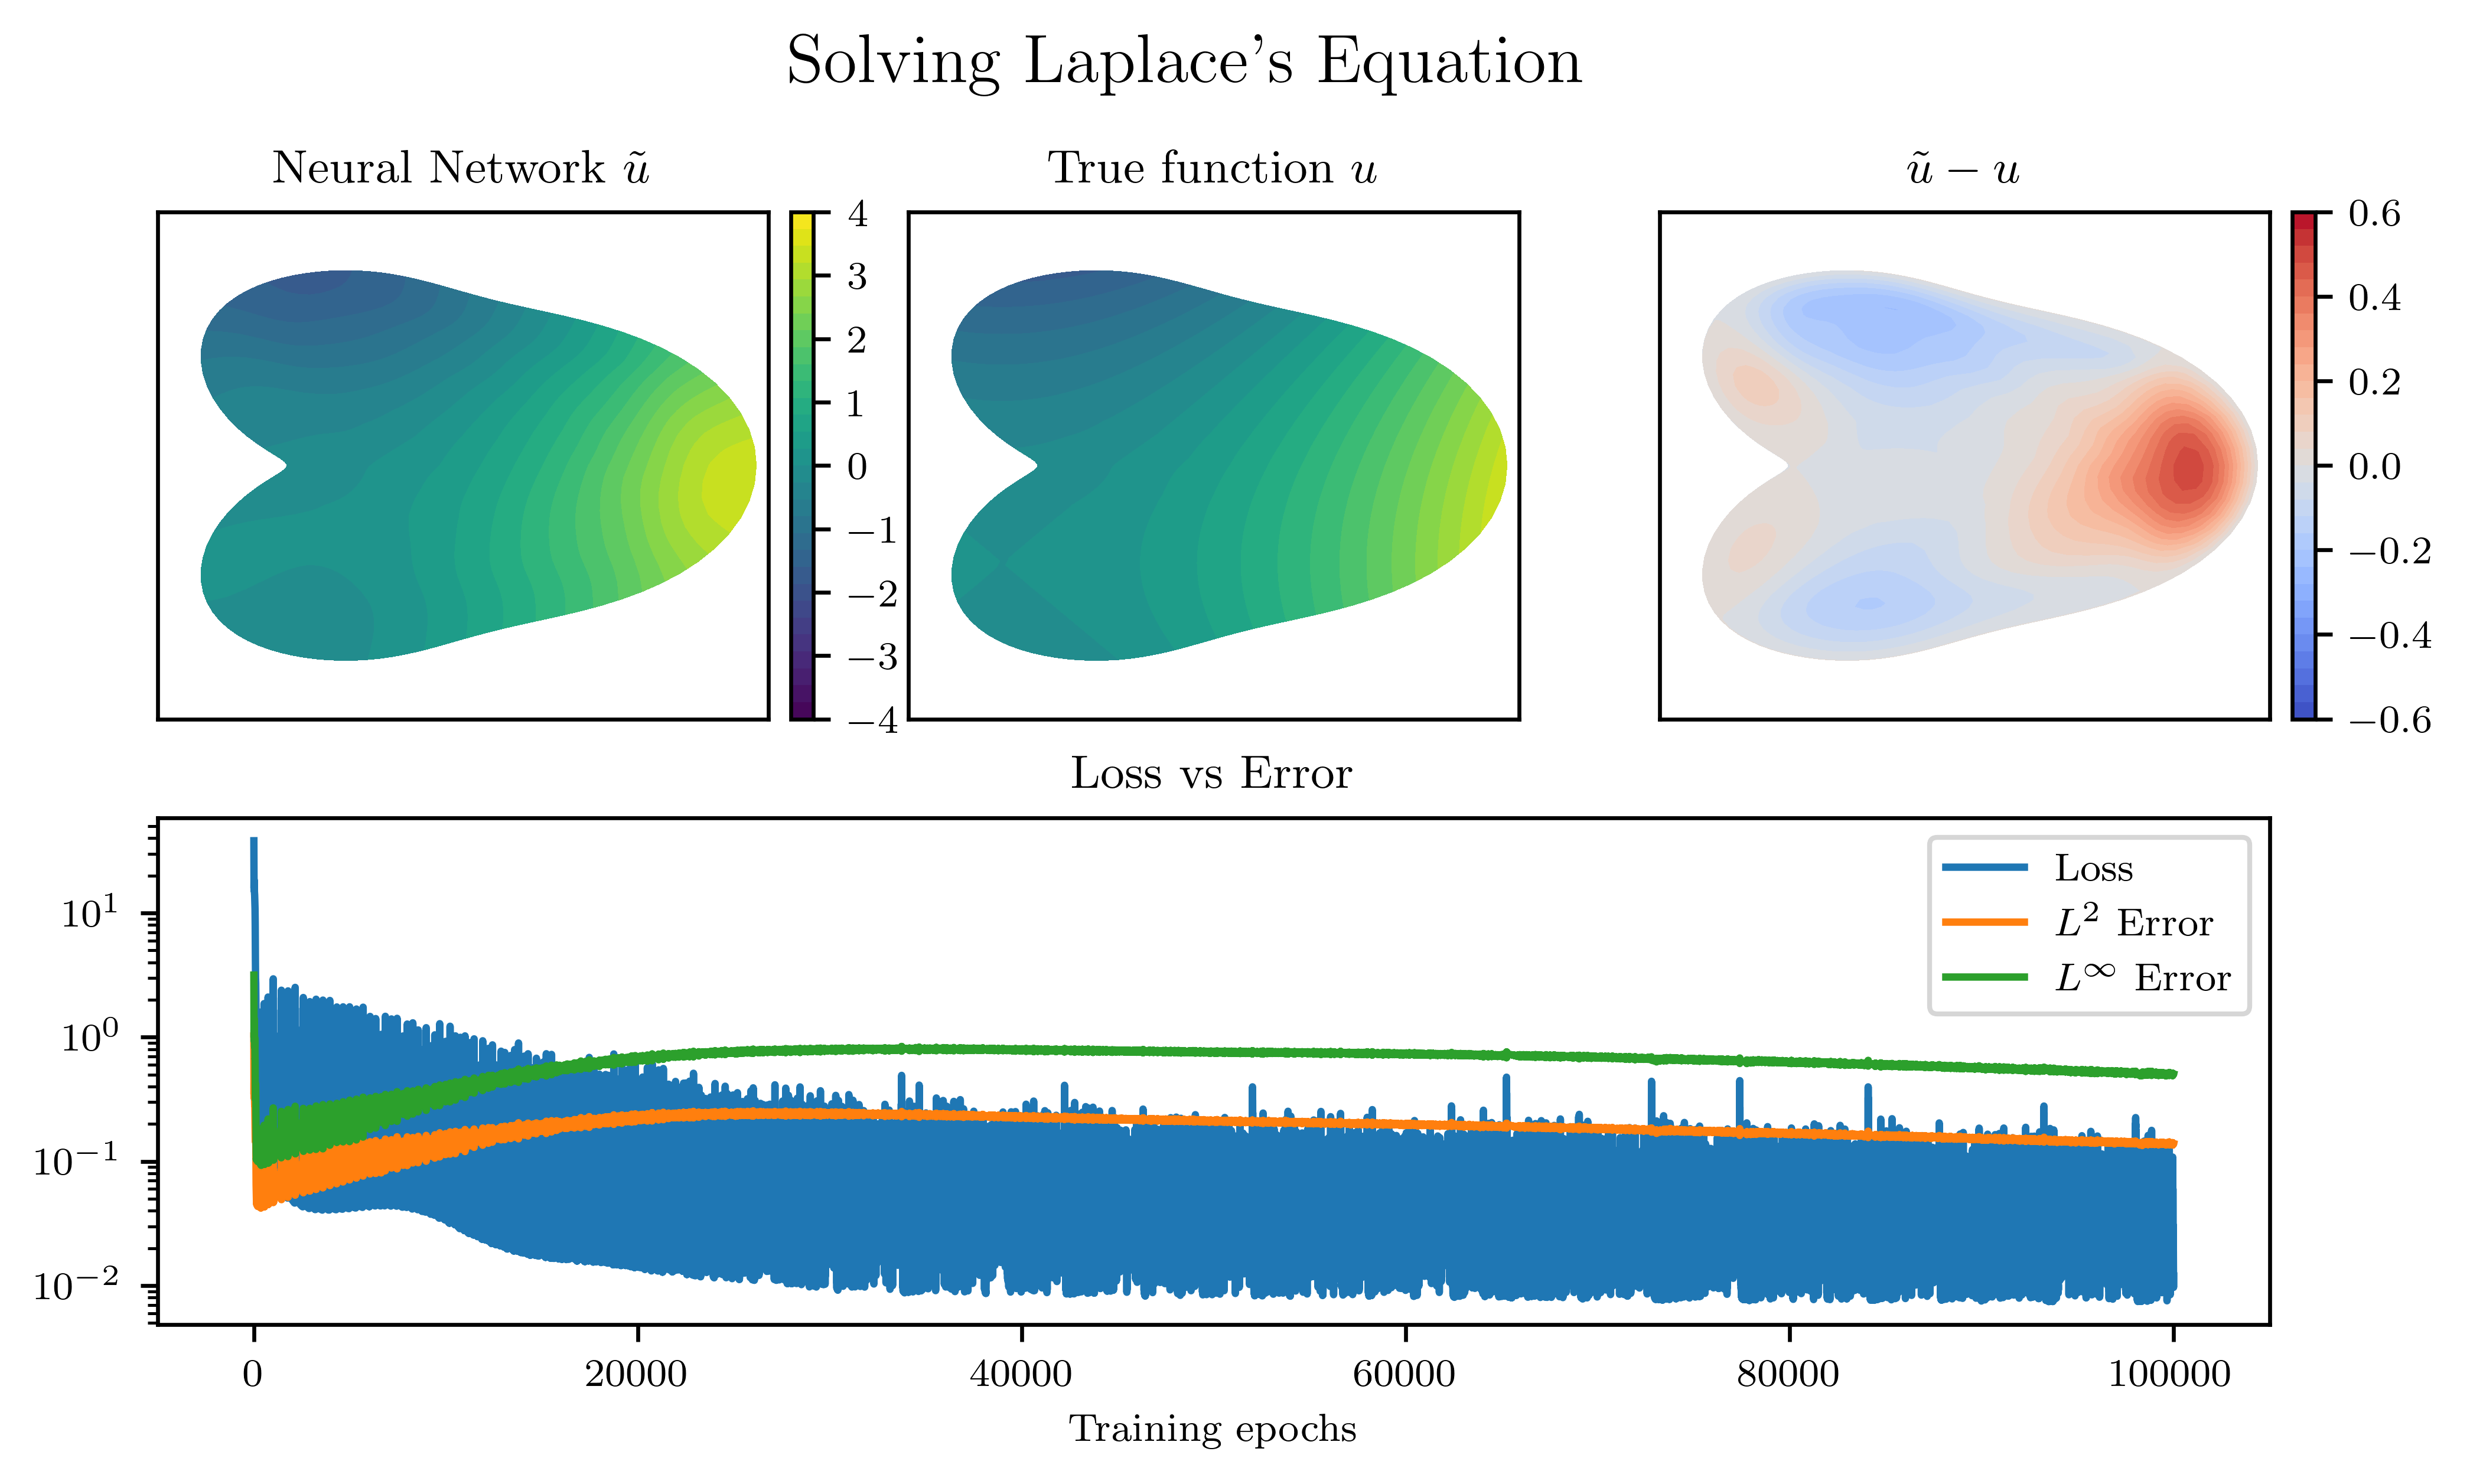

In [8]:
fig = plt.figure(figsize=[6.4,4.0])

ax0 = plt.subplot(2,3,1)
ax1 = plt.subplot(2,3,2)
ax2 = plt.subplot(2,3,3)
ax3 = plt.subplot(2,1,2)

fig.suptitle(title, y=1.0, fontsize=14)

levels = np.linspace(-4.0, 4.0, 31)
level_tick = np.linspace(-4.0, 4.0, 9)

plt.tight_layout(pad=0.4, rect=[0, 0.03, 1, 0.95])

ax0.set_title(r'Neural Network $\tilde{u}$')

ax0.set_xlim(xmin, xmax)
ax0.set_ylim(ymin, ymax)
contour0 = ax0.contourf( Xplot, Yplot, Y, levels=levels, cmap=plt.cm.viridis)
ax0.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)
colorbar0_param = fig.add_axes(
    [ax0.get_position().x1 + 0.01,
     ax0.get_position().y0,
     0.01,
     ax0.get_position().height])
colorbar0 = plt.colorbar(contour0, cax = colorbar0_param, ticks=level_tick)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
ax1.set_title(r'True function $u$')
contour1 = ax1.contourf( Xplot, Yplot, Ytrue, levels=levels, cmap=plt.cm.viridis)
ax1.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
ax2.set_title(r'$\tilde{u} - u$')
contour2 = ax2.contourf( Xplot, Yplot, Y - Ytrue, levels = error_levels, cmap=plt.cm.coolwarm)
ax2.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)
colorbar2_param = fig.add_axes(
    [ax2.get_position().x1 + 0.01,
     ax2.get_position().y0,
     0.01,
     ax2.get_position().height])
colorbar2 = plt.colorbar(contour2, cax = colorbar2_param, ticks=error_tick)

steps = int(parameters['trainingsteps'])
L2loss = losses[:,:,0]
Linfloss = np.sqrt(losses[:,:,1])
L2error = np.sqrt(errors[:,:,0])
Linferror = np.sqrt(np.amax( errors[:,:,1], axis=1))

ax3.set_title('Loss and Errors')

ax3.semilogy(range(steps), np.sqrt(L2loss[:,0] + 0.1*L2loss[:,1]))
#ax.semilogy(range(steps), np.sqrt(L2loss[:,1]))
#ax.semilogy(range(steps), np.sqrt(Linfloss[:,0]))}
ax3.semilogy(range(steps), L2error[:,0])
ax3.semilogy(range(steps), Linferror)
ax3.legend(['Loss', r'$L^2$ Error', r'$L^{\infty}$ Error'])
ax3.set_xlabel('Training epochs')
ax3.set_title('Loss vs Error')
#ax[1].semilogy(steps, np.abs( 5.1148*L2loss - L2error) )

### Plotting Errors and Losses vs Steps

In [5]:
steps = range(int(parameters['trainingsteps']))
L2loss = losses[:,:,0]
Linfloss = losses[:,:,1]
L2error = np.sqrt(errors[:,:,0])
Linferror = np.sqrt(np.amax(errors[-1,:,:]))

print('Relative Interior L2 error = {:.4f}'.format(L2error[-1,0]))
print('Relative Boundary L2 error = {:.4f}'.format(L2error[-1,1]))
print('Linf error = {:.4f}'.format(Linferror))

# Volume of domain: 0.894119
# Length of boundary: 3.7286
# Integral of true: 0.4220
# Integral of true squared: 1.2000

Relative Interior L2 error = 0.1388
Relative Boundary L2 error = 0.0294
Linf error = 0.5043
